In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

In [5]:
numerical   = pd.read_csv('files_for_lab/numerical.csv')
categorical = pd.read_csv('files_for_lab/categorical.csv')
target      = pd.read_csv('files_for_lab/target.csv')

In [8]:
print(numerical.shape)
print(categorical.shape)
print(target.shape)

(95412, 315)
(95412, 22)
(95412, 2)


In [12]:
data = pd.concat([numerical, categorical, target], axis = 1)
data['TARGET_B'].value_counts()

0    90569
1     4843
Name: TARGET_B, dtype: int64

In [16]:
data.isna().sum().sum()

0

In [18]:
data.shape

(95412, 339)

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

y = data['TARGET_B']
X = data.drop(['TARGET_B','TARGET_D'], axis = 1)

numericalX = X.select_dtypes(np.number)
categoricalX = X.select_dtypes(np.object)

# scaling 

scaler = MinMaxScaler()
scaler.fit(numericalX)
scaled_numerical = scaler.transform(numericalX)
scaled_numerical = pd.DataFrame(scaled_numerical, columns = numericalX.columns)

# encoding

display(categoricalX.head())

for col in categoricalX.columns:
    print(col, categoricalX[col].nunique())

encoder = OneHotEncoder(drop='first').fit(categoricalX)
encoded_categorical = encoder.transform(categoricalX).toarray()
cols = encoder.get_feature_names_out()
encoded_categorical = pd.DataFrame(encoded_categorical, columns=cols)

# concat

X = pd.concat([scaled_numerical, encoded_categorical], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

/var/folders/40/fpzt8rqs1hd_nf7fht4s6n240000gn/T/ipykernel_19273/2858371737.py:9: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categoricalX = X.select_dtypes(np.object)


,STATE,HOMEOWNR,GENDER,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A
0,IL,H,F,L,E,C,T
1,CA,H,M,L,G,A,S
2,NC,U,M,L,E,C,R
3,CA,U,F,L,E,C,R
4,FL,H,F,L,F,A,S


STATE 12
HOMEOWNR 2
GENDER 3
RFA_2R 1
RFA_2A 4
GEOCODE2 4
DOMAIN_A 5


## Decission Tree

In [51]:
from sklearn.tree import DecisionTreeClassifier

regr = DecisionTreeClassifier(max_depth=10,
                             criterion = 'gini',
                             min_samples_split=10,
                             min_samples_leaf = 5,
                             max_features = 6)

model = regr.fit(X_train, y_train)
print("Train data score was: {:.2f} ".format(regr.score(X_train, y_train)))
print("Test data score was: {:.2f}".format(regr.score(X_test, y_test)))

Train data score was: 0.95 
Test data score was: 0.95


In [45]:
# now upsample
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=100,k_neighbors=3)
X_train_SMOTE,y_train_SMOTE = sm.fit_resample(X_train,y_train)

print(X_train.shape)
print(X_train_SMOTE.shape)


(76329, 354)
(144972, 354)


In [130]:
model = regr.fit(X_train_SMOTE, y_train_SMOTE)
print("Upscaled train data score was: {:.2f} ".format(regr.score(X_train_SMOTE, y_train_SMOTE)))
print("Test data score was: {:.2f}".format(regr.score(X_test, y_test)))
print("Full data score was: {:.2f}".format(regr.score(X,y)))
#text_representation = tree.export_text(regr)
#print(text_representation)

Upscaled train data score was: 0.77 
Test data score was: 0.70
Full data score was: 0.71


In [131]:
from sklearn.metrics import confusion_matrix

y_pred = regr.predict(X_test)
display(y_test.value_counts())
display(confusion_matrix(y_test, y_pred))

0    18083
1     1000
Name: TARGET_B, dtype: int64

array([[13178,  4905],
       [  728,   272]])

## Random Forest

In [118]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=5,
                             min_samples_split=20,
                             min_samples_leaf =20,
                             max_samples=0.8,
                             random_state = 42)
clf.fit(X_train_SMOTE, y_train_SMOTE)

print("The accuracy for the Random Forest in the TRAIN set is {:.2f}".format(clf.score(X_train_SMOTE, y_train_SMOTE)))
print("The accuracy for the Random Forest in the TEST  set is {:.2f}".format(clf.score(X_test, y_test)))
print("The accuracy for the Random Forest in the FULL  set is {:.2f}".format(clf.score(X, y)))

y_pred = clf.predict(X)
display(y_test.value_counts())
display(confusion_matrix(y, y_pred))

The accuracy for the Random Forest in the TRAIN set is 0.88
The accuracy for the Random Forest in the TEST  set is 0.83
The accuracy for the Random Forest in the FULL  set is 0.84


0    18083
1     1000
Name: TARGET_B, dtype: int64

array([[79081, 11488],
       [ 3911,   932]])

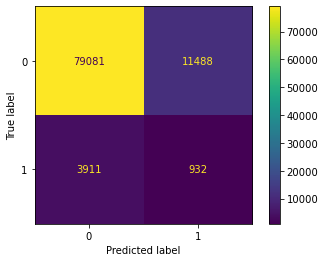

In [65]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(X)

cm = confusion_matrix(y, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

## the model produces too many type 1 and type 2 errors. 
## from business standpoint you compare the cost of the letter and expected donation
## so the cost of false positive is the cost of the mailings (0.7 usd)
## the cost of false negative is the mean donation (16 usd) less the cost of the mailing
## the cost of one false negative exceeds the cost of one false positive
## if we try to increase the donations and bias the model towards the positive results, 
## we encrease the number of false positives. 
## We can do it untill the marginal costs of false mailings is less than the marginal revenue.

# Revenue = true_positive * (mean_donation)
# Costs = true_positive * (mail) + false_positive * (mail)
# Target function = revenue - costs (max)

## Aside from tuning the hyperparameters of the model we can make our model to be more biased
## towards positive outcomes by applying weights to them. 
## Required weight could be calculated by maximization of the target function

In [115]:
weights = [i/10 for i in range(10,30)]
weight  = []
true_p  = []
false_p = []
mail_c  = 0.68

for w in weights:
    
    clf = RandomForestClassifier(max_depth=5,
                             min_samples_split=20,
                             min_samples_leaf =20,
                             max_samples=0.8,
                             random_state = 42,
                             n_jobs=-1)
    
    clf.fit(X_train_SMOTE, y_train_SMOTE,sample_weight = np.array([w if i == 1 else 1 for i in y_train_SMOTE]))

    y_pred = clf.predict(X)
    print('weight =',w)
    cm = confusion_matrix(y, y_pred)
    display(cm)
    
    weight.append(w)
    true_p.append(cm[1][1])
    false_p.append(cm[0][1])

income = pd.DataFrame({'weight':weight,'true_p':true_p,'false_p':false_p})


weight = 1.0


array([[79081, 11488],
       [ 3911,   932]])

weight = 1.1


array([[74969, 15600],
       [ 3616,  1227]])

weight = 1.2


array([[70688, 19881],
       [ 3306,  1537]])

weight = 1.3


array([[66128, 24441],
       [ 3007,  1836]])

weight = 1.4


array([[61656, 28913],
       [ 2742,  2101]])

weight = 1.5


array([[57429, 33140],
       [ 2500,  2343]])

weight = 1.6


array([[53260, 37309],
       [ 2260,  2583]])

weight = 1.7


array([[49487, 41082],
       [ 2031,  2812]])

weight = 1.8


array([[45554, 45015],
       [ 1840,  3003]])

weight = 1.9


array([[42048, 48521],
       [ 1654,  3189]])

weight = 2.0


array([[38793, 51776],
       [ 1508,  3335]])

weight = 2.1


array([[35152, 55417],
       [ 1353,  3490]])

weight = 2.2


array([[32646, 57923],
       [ 1232,  3611]])

weight = 2.3


array([[29618, 60951],
       [ 1084,  3759]])

weight = 2.4


array([[27511, 63058],
       [  991,  3852]])

weight = 2.5


array([[25560, 65009],
       [  894,  3949]])

weight = 2.6


array([[23595, 66974],
       [  814,  4029]])

weight = 2.7


array([[22168, 68401],
       [  741,  4102]])

weight = 2.8


array([[20429, 70140],
       [  659,  4184]])

weight = 2.9


array([[18964, 71605],
       [  589,  4254]])

In [121]:
donat   = data[data['TARGET_D']>0]['TARGET_D'].mean()
income['revenue'] =(income['true_p']*donat).round(2)
income['costs']   =(income['true_p']+income['false_p'])*mail_c
income['profit']  =(income['revenue']-income['costs']).round(2)
income

,weight,true_p,false_p,revenue,costs,profit
0,1.0,932,11488,14561.89,8445.60,6116.29
1,1.1,1227,15600,19171.07,11442.36,7728.71
2,1.2,1537,19881,24014.62,14564.24,9450.38
3,1.3,1836,24441,28686.30,17868.36,10817.94
4,1.4,2101,28913,32826.75,21089.52,11737.23
5,1.5,2343,33140,36607.84,24128.44,12479.40
6,1.6,2583,37309,40357.68,27126.56,13231.12
7,1.7,2812,41082,43935.66,29847.92,14087.74
8,1.8,3003,45015,46919.91,32652.24,14267.67
9,1.9,3189,48521,49826.03,35162.80,14663.23


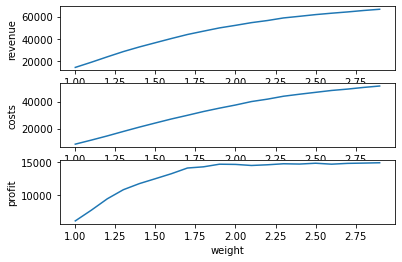

In [129]:
fig, ax1 = plt.subplots(3,1) #figsize=(width,hight)
sns.lineplot(x='weight', y='revenue',data=income, ax=ax1[0])
sns.lineplot(x='weight', y='costs',data=income, ax=ax1[1])
sns.lineplot(x='weight', y='profit',data=income, ax=ax1[2])

plt.show()

## the growth of profit stops at weight 1.9.